In [1]:
import torch
import torch.nn.functional as F
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import h5py
import scipy
from scipy.signal import find_peaks
from IPython.display import Image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
class load_dataset(Dataset):
    def __init__(self, path,device):
        data = scipy.io.loadmat(path)['imagingData']['samples'][0,0]
        self.y = torch.zeros((len(data), data[0].shape[0]*data[0].shape[1]), device=device)
        for i in range(len(data)):
          self.y[i] = torch.tensor(data[i].flatten())
        self.y = torch.unsqueeze(self.y, 1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.y[idx]

# create dataset
dataset = load_dataset(r'./data.mat',device = device)
print(dataset[0].shape)

torch.Size([1, 14400])


In [3]:
def vis_code(x):
    x = x.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))
    for c in range(x.shape[0]):
        xc = x[c,:]
        nz_x = np.where(xc>0)[0]
        plt.plot(np.zeros(xc.shape), "black")
        plt.stem(nz_x, xc[nz_x], label="x{}".format(c+1), linefmt="{}".format(color[c]), markerfmt="o{}".format(color[c]), basefmt="black", use_line_collection=True)
        plt.legend()
        plt.xlabel("Time [ms]")
    return

def vis_code_est(x, xhat):
    x = x.clone().detach().cpu().numpy()
    xhat = xhat.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))

    for c in range(x.shape[0]):
        xc = x[c,:]
        nz_x = np.where(xc>0)[0]
        plt.plot(np.zeros(xc.shape), "black")
        plt.stem(nz_x, xc[nz_x], label="x{}".format(c+1), linefmt="black", markerfmt="o{}".format(color[c]), basefmt="black", use_line_collection=True)
        xchat = xhat[c,:]
        nz_xhat = np.where(xchat>0)[0]
        plt.stem(nz_xhat, xchat[nz_xhat], label="xhat{}".format(c+1), linefmt="-.{}".format(color[c]), markerfmt="*{}".format(color[c]), basefmt="black", use_line_collection=True)
        plt.legend()
        plt.title("x")
        plt.legend()
        plt.xlabel("Time [ms]")
    return

def vis_filters(h):
    h = h.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(5,2))
    for c in range(h.shape[0]):
        plt.plot(h[c,0,:], label="true", color=color[c])
    plt.title("h")
    plt.xlabel("Time [ms]")
    return

def vis_filter_est(h, h_init, h_hat):
    if h is not None:
      h = h.clone().detach().cpu().numpy()
    h_init = h_init.clone().detach().cpu().numpy()
    h_hat = h_hat.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(15,3))
    for c in range(h_init.shape[0]):
        plt.subplot(1,h_init.shape[0],c+1)
        if h is not None:
          plt.plot(h[c,0,:], label="true", color="black")
        plt.plot(h_init[c,0,:], "--", label="init", color="gray")
        plt.plot(h_hat[c,0,:], label="est", color=color[c])
        plt.title("h{}".format(c+1))
        plt.xlabel("Time [ms]")
        plt.legend()
    return

def vis_data(y):
    y = y.clone().detach().cpu().numpy()
    plt.figure(figsize=(20,3))
    plt.plot(y, label="raw", color="black")
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()
    return

def vis_data_est(y,y_hat):
    y = y.clone().detach().cpu().numpy()
    y_hat = y_hat.clone().detach().cpu().numpy()
    plt.figure(figsize=(20,3))
    plt.plot(y, label="raw", color="black")
    plt.plot(y_hat, label="denoised", color="orange")
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()
    return

def vis_data_separated_est(hx1,hx2):
    hx1 = hx1.clone().detach().cpu().numpy()
    hx2 = hx2.clone().detach().cpu().numpy()
    color = ["b", "r"]
    plt.figure(figsize=(20,3))
    plt.plot(hx1, label="1", color=color[0])
    plt.plot(hx2, label="2", color=color[1])
    plt.title("y")
    plt.xlabel("Time [ms]")
    plt.legend()

def vis_miss_false(missed_per_list, false_per_list):
  plt.figure(figsize=(10,5))
  plt.plot(missed_per_list, false_per_list, color="black", label="CRsAE")
  plt.xlabel("True Miss [%]")
  plt.ylabel("False Alarm [%]")
  plt.ylim(0,1.1*np.max(false_per_list))
  plt.xlim(0,1.1*np.max(missed_per_list))
  plt.legend()
  return

def load_filters(device):
    return torch.load("data/h_sim_2.pt").to(device)

def load_h_init_harris(device):
    return torch.load("data/h_init_harris.pt").to(device)

def load_y_harris(device):
    return torch.load("data/y_harris.pt").to(device)

def load_y_series_harris(device):
    return torch.load("data/y_series_harris.pt").to(device)

# create distance measure for dictionary
def compute_err_h(h, h_hat):
    h = h.clone().detach()
    h_hat = h_hat.clone().detach()

    err = torch.zeros(h.shape[0])
    for c in range(h.shape[0]):
        corr = torch.sum(h[c, 0, :] * h_hat[c, 0, :])
        err[c] = torch.sqrt(torch.abs(1 - corr) ** 2)
    return err

def initialize_filter(H):
  flag = 1
  while flag:
    H_init = H + 0.4 * torch.randn(H.shape, device=device)
    H_init = F.normalize(H_init, p=2, dim=-1)
    if torch.max(compute_err_h(H, H_init)) < 0.5:
      if torch.min(compute_err_h(H, H_init)) > 0.4:
        flag = 0

  return H_init

In [4]:
class CRsAE1D(torch.nn.Module):
    def __init__(self, hyp, H=None):
        super(CRsAE1D, self).__init__()

        self.T = hyp["T"]            # number of encoder unfolding
        self.L = hyp["L"]            # 1/L is the step size in the encoder
        self.C = hyp["C"]            # number of filters
        self.K = hyp["K"]            # legnth of the filters
        self.lam = hyp["lam"]        # lambda (regularization parameter)
        self.device = hyp["device"]  # device (i.e., cpu, cuda0)

        # initialize the filter H
        if H is None:
            # initialize with random normal
            H = torch.randn((self.C, 1, self.K), device=self.device)
            # normalize that each filter has norm 1
            H = F.normalize(H, p=2, dim=-1)
        # register the filters as weights of
        # the neural network so that to be trainable.
        self.register_parameter("H", torch.nn.Parameter(H))
        # create ReLU
        self.relu = torch.nn.ReLU()

    def get_param(self, name):
        # get parameters with name
        return self.state_dict(keep_vars=True)[name]

    def normalize(self):
        # normalize the filters
        self.get_param("H").data = F.normalize(self.get_param("H").data, p=2, dim=-1)

    def H_operator(self, x):
        return F.conv_transpose1d(x, self.get_param("H"))

    def HT_operator(self, x):
        return F.conv1d(x, self.get_param("H"))

    def encoder(self, y):
        enc_dim = F.conv1d(y, self.get_param("H")).shape[-1]

        x_old = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        x_tmp = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        x_new = torch.zeros(y.shape[0], self.C, enc_dim, device=self.device)
        s_old = torch.tensor(1, device=self.device).float()

        # T recurrent steps
        for t in range(self.T):
            res = y - self.H_operator(x_tmp)

            x_new = x_tmp + self.HT_operator(res) / self.L

            x_new = self.relu(x_new - self.lam / self.L)

            s_new = (1 + torch.sqrt(1 + 4 * s_old * s_old)) / 2
            x_tmp = x_new + (s_old - 1) / s_new * (x_new - x_old)

            x_old = x_new
            s_old = s_new
        return x_new

    def decoder(self, x):
        return F.conv_transpose1d(x, self.get_param("H"))

    def forward(self, y):
        # encoder
        x = self.encoder(y)
        # decoder
        y_hat = self.decoder(x)
        return y_hat, x

    def separate(self,y):
        with torch.no_grad():
            # encoder
            x = self.encoder(y)

            hx_separate = torch.zeros((y.shape[0], self.C, y.shape[-1]), device=self.device)
            for c in range(self.C):
                xc = torch.unsqueeze(x[:,c,:], dim=1)
                hc = torch.unsqueeze(self.get_param("H")[c,:,:],dim=0)
                hx_separate[:,c,:] =  torch.squeeze(F.conv_transpose1d(xc, hc),dim=1)

        return hx_separate

In [5]:
##########################
######## step 3.1. #######
##### build network ######
##########################

##########################
####### step 3.1.1 ######
##########################
# fill in the gaps
net_hyp = {"T": 800,                 # number of encoder unfolding
           "L": 10,                  # 1/L is the step size in the encoder
           "C": 1,                 # number of filters
           "K": 5,                  # legnth of the filters
           "lam": 1.5,
           "device": device
           }
#H_init = initialize_filter(dataset.H.clone())
##########################
####### step 3.1.2. ######
##########################
# create the newtork with hyperparameters define above, and also H=H_init
net = CRsAE1D(net_hyp)

##########################
######## step 3.2. #######
##########################
# training parameters
train_hyp = {"batch_size": 8, "num_epochs": 50, "lr": 1e-2, "shuffle": True}
# data loader
train_loader = DataLoader(dataset, shuffle=train_hyp["shuffle"], batch_size=train_hyp["batch_size"])
##########################
######## step 3.3. #######
##########################
# criterion
criterion = torch.nn.MSELoss()
##########################
######## step 3.4. #######
##########################
# optimizer
optimizer = optim.Adam(net.parameters(), lr=train_hyp["lr"], eps=1e-3)

In [6]:
##########################
####### step 3.5. ########
######## training ########
##########################

#print("\n start training!")
#print("initial err_H:{:4f}\n".format(torch.mean(compute_err_h(dataset.H, net.get_param("H")))))
# each loop is one pass over the whole dataset
for epoch in tqdm(range(train_hyp["num_epochs"]), disable=True):
    loss_all = 0
    # each loop is a mini-batch
    for idx, y in tqdm(enumerate(train_loader), disable=False):
        # load data input the device
        y = y.to(device)

        ##########################
        ###### step 3.5.1. #######
        ##########################
        # run the network in forward net(y) to get y_hat and x_hat
        y_hat, _= net(y)

        ##########################
        ####### step 3.5.2. ######
        ##########################
        # compute loss using the created criterion
        loss = criterion(y, y_hat)
        loss_all += float(loss.item())

        ##########################
        ####### step 3.5.3 #######
        ##########################
        # set the gradients in the optimizer to zero (optimizer.zero_grad())
        optimizer.zero_grad()
        # do backward on the loss
        loss.backward()
        # take a step with the optimizer
        optimizer.step()

        # normalize filters
        net.normalize()

        #err_h = compute_err_h(dataset.H, net.get_param("H"))
    print("Epoch [{}/{}]loss:{:.4f}\n".format(epoch+1,train_hyp["num_epochs"],loss_all))

3it [00:10,  3.42s/it]


Epoch [1/50]loss:0.6526



3it [00:02,  1.12it/s]


Epoch [2/50]loss:0.6456



3it [00:02,  1.11it/s]


Epoch [3/50]loss:0.6409



3it [00:03,  1.31s/it]


Epoch [4/50]loss:0.6320



3it [00:02,  1.11it/s]


Epoch [5/50]loss:0.6377



3it [00:02,  1.11it/s]


Epoch [6/50]loss:0.6280



3it [00:02,  1.11it/s]


Epoch [7/50]loss:0.6325



3it [00:02,  1.03it/s]


Epoch [8/50]loss:0.6271



3it [00:02,  1.11it/s]


Epoch [9/50]loss:0.6289



3it [00:02,  1.12it/s]


Epoch [10/50]loss:0.6305



3it [00:02,  1.12it/s]


Epoch [11/50]loss:0.6321



3it [00:02,  1.05it/s]


Epoch [12/50]loss:0.6365



3it [00:02,  1.06it/s]


Epoch [13/50]loss:0.6326



3it [00:02,  1.12it/s]


Epoch [14/50]loss:0.6403



3it [00:02,  1.12it/s]


Epoch [15/50]loss:0.6427



3it [00:02,  1.11it/s]


Epoch [16/50]loss:0.6364



3it [00:02,  1.05it/s]


Epoch [17/50]loss:0.6506



3it [00:02,  1.12it/s]


Epoch [18/50]loss:0.6384



3it [00:02,  1.11it/s]


Epoch [19/50]loss:0.6506



3it [00:02,  1.12it/s]


Epoch [20/50]loss:0.6574



3it [00:02,  1.04it/s]


Epoch [21/50]loss:0.6485



3it [00:02,  1.11it/s]


Epoch [22/50]loss:0.6503



3it [00:02,  1.12it/s]


Epoch [23/50]loss:0.6449



3it [00:02,  1.11it/s]


Epoch [24/50]loss:0.6578



3it [00:02,  1.06it/s]


Epoch [25/50]loss:0.6520



3it [00:02,  1.04it/s]


Epoch [26/50]loss:0.6640



3it [00:02,  1.12it/s]


Epoch [27/50]loss:0.6538



3it [00:02,  1.11it/s]


Epoch [28/50]loss:0.6514



3it [00:02,  1.11it/s]


Epoch [29/50]loss:0.6577



3it [00:02,  1.02it/s]


Epoch [30/50]loss:0.6542



3it [00:02,  1.11it/s]


Epoch [31/50]loss:0.6503



3it [00:02,  1.11it/s]


Epoch [32/50]loss:0.6493



3it [00:02,  1.12it/s]


Epoch [33/50]loss:0.6521



3it [00:02,  1.08it/s]


Epoch [34/50]loss:0.6575



3it [00:02,  1.07it/s]


Epoch [35/50]loss:0.6517



3it [00:02,  1.10it/s]


Epoch [36/50]loss:0.6502



3it [00:02,  1.11it/s]


Epoch [37/50]loss:0.6458



3it [00:02,  1.12it/s]


Epoch [38/50]loss:0.6498



3it [00:02,  1.04it/s]


Epoch [39/50]loss:0.6500



3it [00:02,  1.13it/s]


Epoch [40/50]loss:0.6538



3it [00:02,  1.13it/s]


Epoch [41/50]loss:0.6423



3it [00:02,  1.11it/s]


Epoch [42/50]loss:0.6551



3it [00:02,  1.05it/s]


Epoch [43/50]loss:0.6463



3it [00:02,  1.10it/s]


Epoch [44/50]loss:0.6426



3it [00:02,  1.11it/s]


Epoch [45/50]loss:0.6379



3it [00:02,  1.12it/s]


Epoch [46/50]loss:0.6433



3it [00:02,  1.11it/s]


Epoch [47/50]loss:0.6493



3it [00:02,  1.03it/s]


Epoch [48/50]loss:0.6410



3it [00:02,  1.12it/s]


Epoch [49/50]loss:0.6429



3it [00:02,  1.12it/s]

Epoch [50/50]loss:0.6371



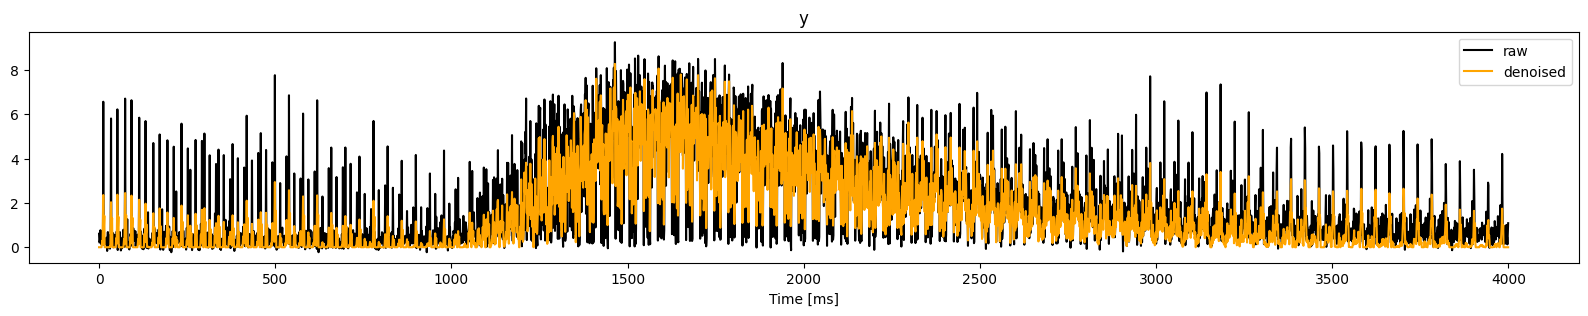

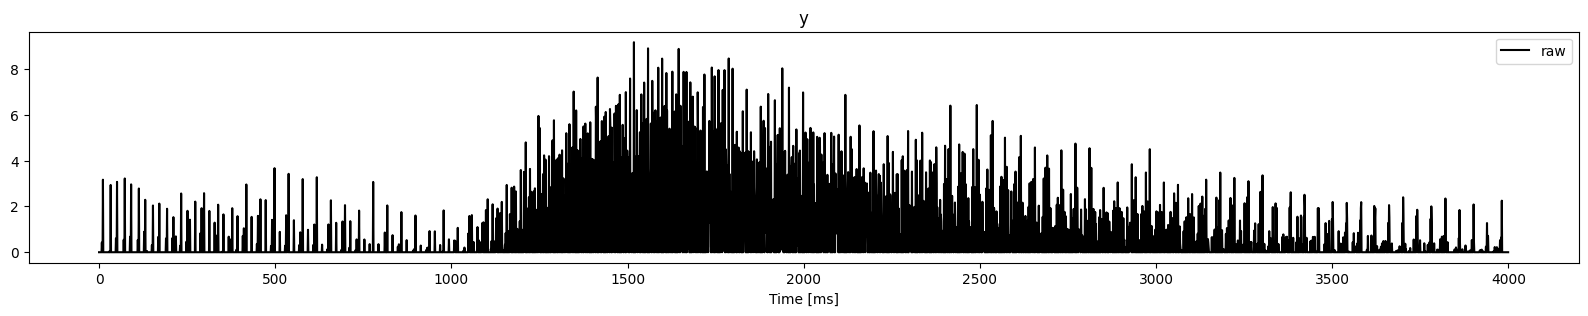

In [12]:
##########################
####### step 3.6. ########
##########################
yi = dataset[0:3]
yi_hat, xi_hat = net(yi)

# this function gets y and gives [h1 * x1, h2 * x2]
#hx = net.separate(yi)

# visualize the filters
#vis_filter_est(dataset.H, H_init, net.get_param("H"))

# visualize the data
vis_data_est(yi[1,0][4000:8000], yi_hat[1,0][4000:8000])

# visualize Hx1 and Hx2
#vis_data_separated_est(hx[0][0], hx[0][1])
vis_data(xi_hat[1,0][4000:8000])
#vis_data(yi_hat[0])

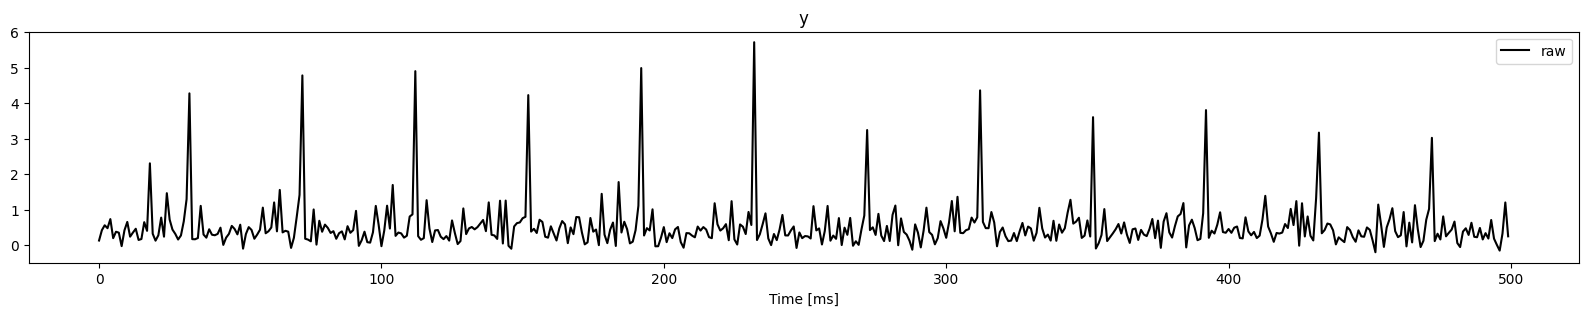

In [8]:
yi = dataset[0:3]
vis_data(yi[1,0][0:500])

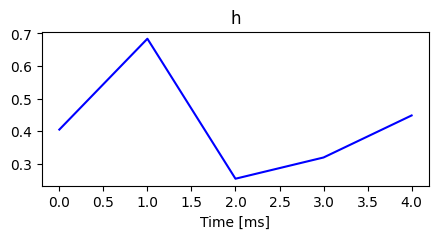

In [13]:
vis_filters(net.get_param("H"))

In [70]:
with torch.no_grad():
  yi = dataset[:]
  yi_hat, xi_hat = net(yi)

xi_hat = torch.nn.functional.pad(xi_hat, (0, 4))

In [71]:
class create_behave_dataset(Dataset):
    def __init__(self, path,x,device):
        self.B_data = scipy.io.loadmat(path)['BehaveData']['success'][0][0][0][0][2]
        self.label = []
        for i in range(len(self.B_data)):
          self.label.append(self.B_data[i][0])
        chunks = torch.split(x, len(self.label), dim=-1)

        # Concatenating the chunks along the first dimension
        output_tensor = torch.cat(chunks, dim=1)

        self.data  = output_tensor.view(len(self.label), -1)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.label[idx] , self.data[idx]

# create dataset



In [116]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


dataset_behave = create_behave_dataset(r'./data.mat',yi,device = device)

linear_accuracy = []
poly_accuracy = []
rbf_accuracy = []
sigmoid_accuracy = []
accuracy_lr = []

X = dataset_behave.data.cpu()
y = dataset_behave.label
# Split the dataset into training and test sets
for _ in range(10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

  # Create an SVM classifier
  # Create SVM classifiers with different kernel functions
  linear_svm = svm.SVC(kernel='linear')
  poly_svm = svm.SVC(kernel='poly', degree=10)
  rbf_svm = svm.SVC(kernel='rbf')
  sigmoid_svm = svm.SVC(kernel='sigmoid')
  lr_classifier = LogisticRegression()

  # Train the classifiers
  linear_svm.fit(X_train, y_train)
  poly_svm.fit(X_train, y_train)
  rbf_svm.fit(X_train, y_train)
  sigmoid_svm.fit(X_train, y_train)
  lr_classifier.fit(X_train, y_train)

  # Make predictions on the test set
  linear_pred = linear_svm.predict(X_test)
  poly_pred = poly_svm.predict(X_test)
  rbf_pred = rbf_svm.predict(X_test)
  sigmoid_pred = sigmoid_svm.predict(X_test)
  lr_pred = lr_classifier.predict(X_test)

  # Evaluate the accuracies of the classifiers
  linear_accuracy.append(accuracy_score(y_test, linear_pred))
  poly_accuracy.append(accuracy_score(y_test, poly_pred))
  rbf_accuracy.append(accuracy_score(y_test, rbf_pred))
  sigmoid_accuracy.append(accuracy_score(y_test, sigmoid_pred))
  accuracy_lr.append(accuracy_score(y_test, lr_pred))


# Print the accuracies
print("Accuracy without network")
print("Linear SVM Accuracy:", np.mean(linear_accuracy))
print("Polynomial SVM Accuracy:", np.mean(poly_accuracy))
print("RBF SVM Accuracy:", np.mean(rbf_accuracy))
print("Sigmoid SVM Accuracy:", np.mean(sigmoid_accuracy))
print("Logistic regression Accuracy:", np.mean(accuracy_lr))

Accuracy without network
Linear SVM Accuracy: 0.275
Polynomial SVM Accuracy: 0.425
RBF SVM Accuracy: 0.325
Sigmoid SVM Accuracy: 0.35
Logistic regression Accuracy: 0.3


In [117]:

dataset_behave = create_behave_dataset(r'./data.mat',xi_hat,device = device)

X = dataset_behave.data.cpu()
y = dataset_behave.label
# Split the dataset into training and test sets
for _ in range(10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

  # Create an SVM classifier
  # Create SVM classifiers with different kernel functions
  linear_svm = svm.SVC(kernel='linear')
  poly_svm = svm.SVC(kernel='poly', degree=10)
  rbf_svm = svm.SVC(kernel='rbf')
  sigmoid_svm = svm.SVC(kernel='sigmoid')
  lr_classifier = LogisticRegression()

  # Train the classifiers
  linear_svm.fit(X_train, y_train)
  poly_svm.fit(X_train, y_train)
  rbf_svm.fit(X_train, y_train)
  sigmoid_svm.fit(X_train, y_train)
  lr_classifier.fit(X_train, y_train)

  # Make predictions on the test set
  linear_pred = linear_svm.predict(X_test)
  poly_pred = poly_svm.predict(X_test)
  rbf_pred = rbf_svm.predict(X_test)
  sigmoid_pred = sigmoid_svm.predict(X_test)
  lr_pred = lr_classifier.predict(X_test)

  # Evaluate the accuracies of the classifiers
  linear_accuracy.append(accuracy_score(y_test, linear_pred))
  poly_accuracy.append(accuracy_score(y_test, poly_pred))
  rbf_accuracy.append(accuracy_score(y_test, rbf_pred))
  sigmoid_accuracy.append(accuracy_score(y_test, sigmoid_pred))
  accuracy_lr.append(accuracy_score(y_test, lr_pred))


# Print the accuracies
print("Accuracy without network")
print("Linear SVM Accuracy:", np.mean(linear_accuracy))
print("Polynomial SVM Accuracy:", np.mean(poly_accuracy))
print("RBF SVM Accuracy:", np.mean(rbf_accuracy))
print("Sigmoid SVM Accuracy:", np.mean(sigmoid_accuracy))
print("Logistic regression Accuracy:", np.mean(accuracy_lr))

Accuracy without network
Linear SVM Accuracy: 0.3875
Polynomial SVM Accuracy: 0.3375
RBF SVM Accuracy: 0.275
Sigmoid SVM Accuracy: 0.3
Logistic regression Accuracy: 0.325


In [118]:
dataset_behave = create_behave_dataset(r'./data.mat',yi_hat,device = device)

X = dataset_behave.data.cpu()
y = dataset_behave.label
# Split the dataset into training and test sets
for _ in range(10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

  # Create an SVM classifier
  # Create SVM classifiers with different kernel functions
  linear_svm = svm.SVC(kernel='linear')
  poly_svm = svm.SVC(kernel='poly', degree=10)
  rbf_svm = svm.SVC(kernel='rbf')
  sigmoid_svm = svm.SVC(kernel='sigmoid')
  lr_classifier = LogisticRegression()

  # Train the classifiers
  linear_svm.fit(X_train, y_train)
  poly_svm.fit(X_train, y_train)
  rbf_svm.fit(X_train, y_train)
  sigmoid_svm.fit(X_train, y_train)
  lr_classifier.fit(X_train, y_train)

  # Make predictions on the test set
  linear_pred = linear_svm.predict(X_test)
  poly_pred = poly_svm.predict(X_test)
  rbf_pred = rbf_svm.predict(X_test)
  sigmoid_pred = sigmoid_svm.predict(X_test)
  lr_pred = lr_classifier.predict(X_test)

  # Evaluate the accuracies of the classifiers
  linear_accuracy.append(accuracy_score(y_test, linear_pred))
  poly_accuracy.append(accuracy_score(y_test, poly_pred))
  rbf_accuracy.append(accuracy_score(y_test, rbf_pred))
  sigmoid_accuracy.append(accuracy_score(y_test, sigmoid_pred))
  accuracy_lr.append(accuracy_score(y_test, lr_pred))


# Print the accuracies
print("Accuracy without network")
print("Linear SVM Accuracy:", np.mean(linear_accuracy))
print("Polynomial SVM Accuracy:", np.mean(poly_accuracy))
print("RBF SVM Accuracy:", np.mean(rbf_accuracy))
print("Sigmoid SVM Accuracy:", np.mean(sigmoid_accuracy))
print("Logistic regression Accuracy:", np.mean(accuracy_lr))

Accuracy without network
Linear SVM Accuracy: 0.36666666666666664
Polynomial SVM Accuracy: 0.35
RBF SVM Accuracy: 0.30833333333333335
Sigmoid SVM Accuracy: 0.3416666666666667
Logistic regression Accuracy: 0.3


In [88]:
print(sum(y)/len(y))

0.475


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a synthetic classification dataset
dataset_behave = create_behave_dataset(r'./data.mat',xi_hat,device = device)

X = dataset_behave.data.cpu()
y = dataset_behave.label


# Define the neural network model
class FC_Net(nn.Module):
    def __init__(self):
        super(FC_Net, self).__init__()
        self.fc1 = nn.Linear(8280, 4140)
        self.fc2 = nn.Linear(4140, 2000)
        self.fc3 = nn.Linear(2000, 1000)
        self.fc4 = nn.Linear(1000, 100)
        self.fc5 = nn.Linear(100, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x


for _ in range(10):
  # Create an instance of the network
  net = FC_Net()

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  accuracy = []
  # Train the network
  num_epochs = 25
  batch_size = 8
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.long)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

    # Evaluate the network
    with torch.no_grad():
        net.eval()
        outputs = net(X_test)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.numpy()

    accuracy.append(accuracy_score(y_test, predicted))
print("Accuracy:", np.mean(accuracy))

<ipython-input-121-af245bfb4640>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-121-af245bfb4640>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


Epoch 1/25, Loss: 4.594711482524872
Epoch 2/25, Loss: 3.134996235370636
Epoch 3/25, Loss: 1.9201276898384094
Epoch 4/25, Loss: 0.8415528759360313
Epoch 5/25, Loss: 0.3496162183323577
Epoch 6/25, Loss: 0.25297120581899435
Epoch 7/25, Loss: 0.18705692142248065
Epoch 8/25, Loss: 0.1273260861635208
Epoch 9/25, Loss: 0.06365875992923975
Epoch 10/25, Loss: 0.027662403997965157
Epoch 11/25, Loss: 0.012335815947153606
Epoch 12/25, Loss: 0.005623358749289764
Epoch 13/25, Loss: 0.002808142957292148
Epoch 14/25, Loss: 0.001605106730494299
Epoch 15/25, Loss: 0.0010528397097004927
Epoch 16/25, Loss: 0.0007614497055783431
Epoch 17/25, Loss: 0.0005955262269026207


In [ ]:
# Generate a synthetic classification dataset
dataset_behave = create_behave_dataset(r'./data.mat',yi_hat,device = device)

X = dataset_behave.data.cpu()
y = dataset_behave.label


for _ in range(10):
  # Create an instance of the network
  net = FC_Net()

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  accuracy = []
  # Train the network
  num_epochs = 25
  batch_size = 8
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.long)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

    # Evaluate the network
    with torch.no_grad():
        net.eval()
        outputs = net(X_test)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.numpy()

    accuracy.append(accuracy_score(y_test, predicted))
print("Accuracy:", np.mean(accuracy))

In [ ]:
# Generate a synthetic classification dataset
dataset_behave = create_behave_dataset(r'./data.mat',yi,device = device)

X = dataset_behave.data.cpu()
y = dataset_behave.label

for _ in range(10):
  # Create an instance of the network
  net = FC_Net()

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)
  accuracy = []
  # Train the network
  num_epochs = 25
  batch_size = 8
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
  X_train = torch.tensor(X_train, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.long)
  X_test = torch.tensor(X_test, dtype=torch.float32)
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss}")

    # Evaluate the network
    with torch.no_grad():
        net.eval()
        outputs = net(X_test)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.numpy()

    accuracy.append(accuracy_score(y_test, predicted))
print("Accuracy:", np.mean(accuracy))